# The idea

Select, for example, 10 abstracts from each year range, feed them through ChatGPT manualy (:D) and extract the top 5/10 keywords and/or sentiments for each of them, manualy (:D) , make them as nodes and edges for each paper . This will connect different articles, but will also need some weights. We'll see

In [89]:
import pandas as pd
import igraph as ig

In [90]:
nlp = pd.read_parquet('project_data/arxiv_nlp.parquet',engine='pyarrow')
climate = pd.read_parquet('project_data/arxiv_climate_change.parquet',engine='pyarrow')

In [91]:
nlp['update_range'].unique()

['2007-2012', '2019-2023', '2013-2018']
Categories (3, object): ['2007-2012' < '2013-2018' < '2019-2023']

In [92]:
ranges = nlp['update_range'].unique() # get the ranges

sample_nlp_1=pd.DataFrame(nlp[nlp['update_range']==ranges[0]]['abstract'].sample(n=10,random_state=1))
sample_nlp_2=pd.DataFrame(nlp[nlp['update_range']==ranges[1]]['abstract'].sample(n=10,random_state=1))
sample_nlp_3=pd.DataFrame(nlp[nlp['update_range']==ranges[2]]['abstract'].sample(n=10,random_state=1))

nlp_samples = [sample_nlp_1,sample_nlp_2,sample_nlp_3]

In [93]:
sample_climate_1=pd.DataFrame(climate[climate['update_range']==ranges[0]]['abstract'].sample(n=10,random_state=1))
sample_climate_2=pd.DataFrame(climate[climate['update_range']==ranges[1]]['abstract'].sample(n=10,random_state=1))
sample_climate_3=pd.DataFrame(climate[climate['update_range']==ranges[2]]['abstract'].sample(n=10,random_state=1))

climate_samples = [sample_climate_1,sample_climate_2,sample_climate_3]

# NLP

## NLP txt files
These will be copied and pasted to ChatGPT manually

In [94]:
output_files = ['project_data/nlp_abstracts_1.txt','project_data/nlp_abstracts_2.txt','project_data/nlp_abstracts_3.txt']  # File name for the output .txt file

for j in range(3):
    # Open the file in write mode
    with open(output_files[j], 'w') as f:
        # Iterate over the rows of the DataFrame,
        k=0
        for i, row in nlp_samples[j].iterrows():
            abstract = row['abstract']  # Get the 'abstract' value from the row
            f.write(f"{k+1}\n{abstract}\n")  # Write the row number and abstract to the file with appropriate line breaks
            k+=1

##  NLP dictionaries for node IDs

In [95]:
nlp_abs_kws_1=[["WordNet", "computational linguists", "Roget's Thesaurus", "machine-tractable version", "semantic similarity"],
["Named Entities", "Natural Language Processing", "NER task", "syntactic context", "large-scale resources"],
["Lexicon-Grammar tables", "Natural Language Processing", "syntactic lexicon", "NLP", "French verbs"],
["lightest derivation", "weighted rules", "AI", "A* search", "computer vision"],
["Natural Language Parsing","Probabilistic Parsers","Computational Grammar Formalism","Indian languages","Research area"],
["semantic web search", "Natural Language Processing", "semantic search engine", "ontology", "keyword expansion"],
["CLARE system", "natural language processing", "reasoning", "response generation", "Core Language Engine"],
["Dynamic Bayesian networks", "language modeling", "information extraction", "shallow parsing", "named entity recognition"],
["cluster features", "part-of-speech tagging", "distributional similarity", "English", "French"],
["dark matter", "super-weakly interacting", "neutrino telescopes", "charged NLPs", "particle physics"]]

nlp_abs_kws_2=[['neural networks', 'natural language processing', 'interpretability', 'machine learning algorithms', 'structured data'],
['transformer', 'attention-based encoder-decoder architecture', 'computer vision', 'medical imaging', 'convolutional neural networks'],
['contextualized embeddings', 'deep neural network-based language models', 'linguistic probes', 'language structure', 'linguistic structures'],
['dialogue systems', 'deep learning based', 'state-of-the-art research outcomes', 'model type', 'system type'],
['gradient-based explanation methods', 'interpreting complex deep neural networks', 'model reliability', 'aspect-based sentiment classification', 'interpretability'],
['autonomous driving', 'deep neural networks', 'fatal accidents', 'metamorphic testing technique', 'real-world traffic scenarios'],
['temporal and numerical expression understanding', 'downstream Natural Language Processing', 'Information Retrieval tasks', 'extraction normalization', 'rule-based system'],
['interpretability or explainability', 'emerging research field', 'legal text', 'rationale constraints', 'paragraph-level rationales'],
['online hate speech', 'Natural Language Processing', 'word representation', 'deep model', 'transfer learning language model'],
['disinformation', 'long textual articles', 'health domains', 'unsupervised task', 'sentence level disinformation']]

nlp_abs_kws_3=[['Paraphrase generation', 'NLP tasks', 'Question answering', 'Information retrieval', 'Conversational systems'],
['Neural language models', 'NLP tasks', 'Mobile devices', 'Softmax layer approximation', 'Machine translation'],
['Linguistic style', 'Image captions', 'Visual grounding', 'SemStyle model', 'Natural language processing techniques'],
['Forensic linguistics', 'Natural Language Processing (NLP)', 'Machine learning techniques', 'Ethical concerns', 'Scientific limitations'],
['Quantum-based methods', 'Information retrieval (IR)', 'Natural language processing (NLP)', 'Quantum meaning-based framework', 'Latent Semantic Analysis (LSA)'],
['Word clustering', 'Natural language processing (NLP)', 'Spectral clustering', 'Semantic role labeling', 'Dependency parsing'],
['Statistical significance testing', 'Experimental results', 'NLP papers', 'Evaluation measures', 'Statistical tests'],
['Topic segmentation', 'Conversation analysis', 'Natural Language Processing (NLP)', 'Graph-based methods', 'Asynchronous conversations'],
['Question answering (QA)', 'Large-scale datasets', 'Electronic medical records', 'Repurposing annotations', 'i2b2 datasets'],
['Neural language models (NLMs)', 'Computationally demanding', 'Softmax layer approximation', 'Fast Graph Decoder (FGD)', 'Neural machine translation']]

In [96]:

def get_unique_words(ll):
    aw=[]
    cats=[]
    for l in ll:
        for i in l:
            aw.append(i.lower())
    return list(set(aw))

def kws_to_dict(unique_words):
    
    nlp_ids={}
    
    k=0
    for word in unique_words:
        nlp_ids[word.split('\n')[0]]=k
        k+=1
        
    return nlp_ids



In [122]:
kw_ids_1=kws_to_dict(get_unique_words(nlp_abs_kws_1))
kw_ids_2=kws_to_dict(get_unique_words(nlp_abs_kws_2))
kw_ids_3=kws_to_dict(get_unique_words(nlp_abs_kws_3))

Words to IDs

In [123]:
nlp_with_ids1 = [[kw_ids_1[word.lower()] for word in keyword_list] for keyword_list in nlp_abs_kws_1]
nlp_with_ids2 = [[kw_ids_2[word.lower()] for word in keyword_list] for keyword_list in nlp_abs_kws_2]
nlp_with_ids3 = [[kw_ids_3[word.lower()] for word in keyword_list] for keyword_list in nlp_abs_kws_3]

In [124]:
G = ig.Graph()
nodes =list( kw_ids_1.values())
G.add_vertices(nodes)


for art in nlp_with_ids1:
    
    for i in range(len(art)):
        for j in range(i + 1, len(art)):
            G.add_edge(art[i], art[j])

In [127]:
G.vs['name']=list(kw_ids_1.keys())
ig.plot(G,vertex_label=G.vs['name'])#G.vs['keyword'])
G.write('project_data/nlp1.graphml')

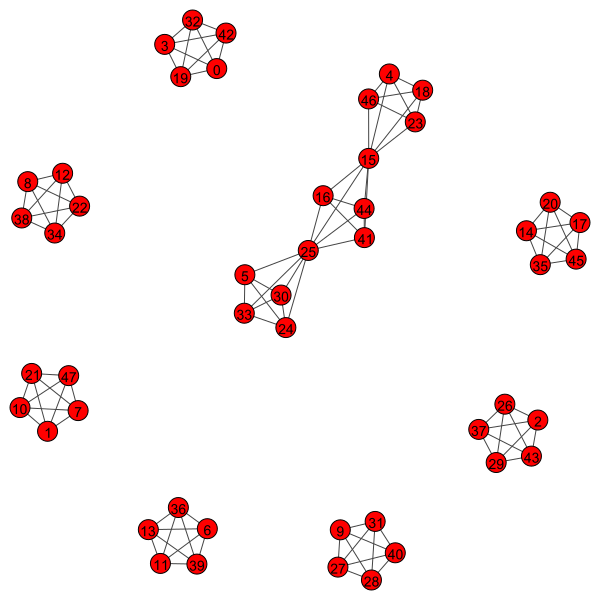

In [101]:
G = ig.Graph()
nodes =list( kw_ids_2.values())
G.add_vertices(nodes)


for art in nlp_with_ids2:
    
    for i in range(len(art)):
        for j in range(i + 1, len(art)):
            G.add_edge(art[i], art[j])
ig.plot(G,vertex_label=nodes)

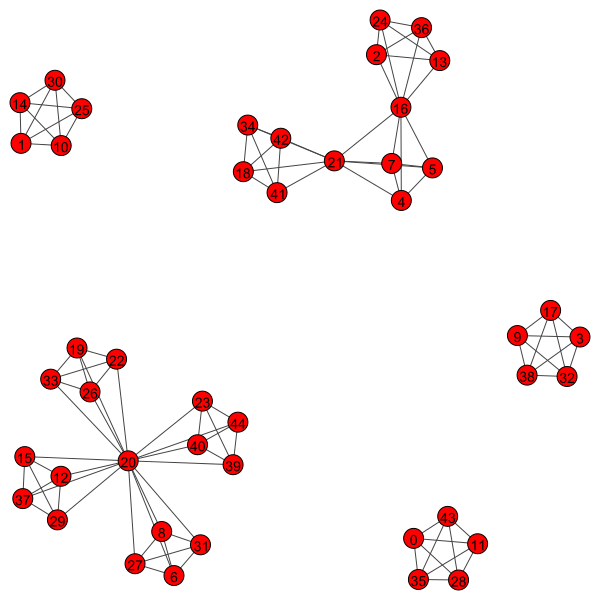

In [102]:
G = ig.Graph()
nodes =list( kw_ids_3.values())
G.add_vertices(nodes)


for art in nlp_with_ids3:
    
    for i in range(len(art)):
        for j in range(i + 1, len(art)):
            G.add_edge(art[i], art[j])
ig.plot(G,vertex_label=nodes)

# Climate change

In [103]:
output_files = ['project_data/climate_abstracts_1.txt','project_data/climate_abstracts_2.txt','project_data/climate_abstracts_3.txt']  # File name for the output .txt file

for j in range(3):
    # Open the file in write mode
    with open(output_files[j], 'w') as f:
        # Iterate over the rows of the DataFrame,
        k=0
        for i, row in climate_samples[j].iterrows():
            abstract = row['abstract']  # Get the 'abstract' value from the row
            f.write(f"{k+1}\n{abstract}\n")  # Write the row number and abstract to the file with appropriate line breaks
            k+=1

In [128]:
climate_abs_kws_1 = [['Fractal fluctuations','Eddy continuum','Probability distribution','Power spectra',
'Global warming'],
['Global surface temperature','Fluctuation','Global warming','Statistical significance','Humankind'],
['Widening tropical belt','Solar activity','Anthropogenic climate change','Tropical zone','Future evolution'],
['Agent-based model','Competition for limited resources','Climate change adaptation','Ecological constraints','Habitat-specific'],
['Cyclical model','Climate change','Glaciation','Two-state model','Quantum Mechanics'],
['Low-frequency variability','Planetary waves','Non-Gaussian statistics','Bimodal behavior','Upper tropospheric jet'],
['Climate modification measures','Control theory','Climate regulator','Last-ditch measure','Global warming'],
['Low-Earth-Orbit system','LEO Archipelago','Space development','Space elevator','Solar-powered lasers'],
['Africa continental margin','Climate change','Erosion','Sedimentation','Neogene emplacement'],
['Thermohaline Circulation','Global warming conditions','Radiative forcing','THC pattern','Latent heat transport']]

climate_abs_kws_2 = [['forests', 'renewable raw material', 'storing carbon', 'climate change mitigation', 'forest damage risk'],
['integrated assessment models', 'variable renewable electricity', 'decarbonizing the power sector', 'spatio-temporal resolutions', 'endogenous investment decisions'],
['research on climate change', 'policy documents', 'climate policy cycles', 'climate change policy documents', 'policy impact'],
['hurricane-caused blackouts', 'heat extremes', 'changing climate', 'resilience of coastal power systems', 'climate adaptation actions'],
['Computing Research Association', 'Building Resilience to Climate-Driven Extreme Events with Computing Innovations', 'impact areas', 'Convergence Accelerator research track', 'climate change'],
['blocking events', 'atmospheric model', 'unstable periodic orbits', 'predictability', 'climate change'],
['deep learning', 'Raw Produce Quality Detection', 'Transformer-based models', 'compute-efficient', 'real-world setting'],
['extreme weather', 'physics-based numerical weather prediction', 'data-driven deep learning Earth system emulator', 'medium-range forecasts', 'global forecast resolutions'],
['population growth', 'food production', 'catastrophic anthropogenic climate change', 'direct heating of the planet', 'energy use'],
['deep learning approaches', 'high-dimensional data', 'interpreting deep neural networks', 'reducing complexity', 'changes in climate']]

climate_abs_kws_3 = [['Anthropogenic', 'Natural changes', 'Solar cycles', 'Solar disk', 'Climatic variability'],
['Scalar reaction diffusion equation', 'Population survival', 'Large-time behavior', 'Nonlinear reaction term', 'Travelling waves'],
['Cosmic rays', 'Halogenated molecules', 'O3 depletion', 'Global climate change', 'Montreal Protocol'],
['Temperature extremes', 'Climate change', 'Local extremes', 'Record highs', 'Null hypothesis'],
['Antarctic ice sheet', 'Climate forcings', 'Coastal flooding risks', 'Marine Ice Sheet Instability (MISI)', 'Marine Ice Cliff Instability (MICI)'],
['Boolean Delay Equations (BDEs)', 'Conservative BDEs', 'Dissipative BDEs', 'Climate change modeling', 'Dynamical systems'],
['Solar spectral irradiance (SSI)', 'SSI variability', "Earth's atmosphere", 'Shortwave heating', 'Chemistry-climate model (CCM) simulations'],
['Optimal energies', 'Cosmic evolution', 'Global warming', 'Smart machines', 'Energy-flow modeling'],
['Tipping points', 'Bifurcations', 'Noise-induced tipping', 'Rapid changes', 'Global energy balance model'],
['Trait-based ecology', 'Trait distributions', 'Metabolic scaling', 'Community assembly', 'Climate change impacts']]


In [129]:
kw_ids_1=kws_to_dict(get_unique_words(climate_abs_kws_1))
kw_ids_2=kws_to_dict(get_unique_words(climate_abs_kws_2))
kw_ids_3=kws_to_dict(get_unique_words(climate_abs_kws_3))

climate_with_ids1 = [[kw_ids_1[word.lower()] for word in keyword_list] for keyword_list in climate_abs_kws_1]
climate_with_ids2 = [[kw_ids_2[word.lower()] for word in keyword_list] for keyword_list in climate_abs_kws_2]
climate_with_ids3 = [[kw_ids_3[word.lower()] for word in keyword_list] for keyword_list in climate_abs_kws_3]

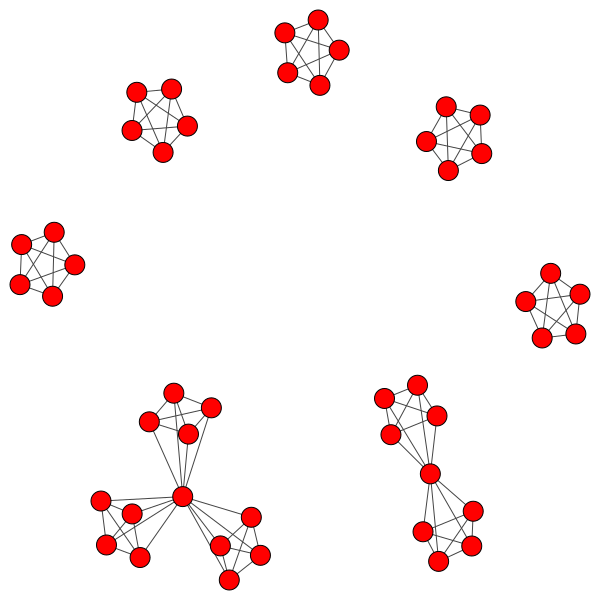

In [130]:
G = ig.Graph()
nodes =list( kw_ids_1.values())
G.add_vertices(nodes)


for art in climate_with_ids1:
    
    for i in range(len(art)):
        for j in range(i + 1, len(art)):
            G.add_edge(art[i], art[j])
            
ig.plot(G)

In [131]:
G.vs['name']=list(kw_ids_1.keys())
ig.plot(G,vertex_label=G.vs['name'])#G.vs['keyword'])
G.write('project_data/climate1.graphml')

In [133]:
G = ig.Graph()
nodes =list( kw_ids_2.values())
G.add_vertices(nodes)


for art in climate_with_ids2:
    
    for i in range(len(art)):
        for j in range(i + 1, len(art)):
            G.add_edge(art[i], art[j])

G.vs['name']=list(kw_ids_2.keys())
ig.plot(G,vertex_label=G.vs['name'])#G.vs['keyword'])
G.write('project_data/climate2.graphml')

In [134]:
G = ig.Graph()
nodes =list( kw_ids_3.values())
G.add_vertices(nodes)


for art in climate_with_ids3:
    
    for i in range(len(art)):
        for j in range(i + 1, len(art)):
            G.add_edge(art[i], art[j])
            
G.vs['name']=list(kw_ids_3.keys())
ig.plot(G,vertex_label=G.vs['name'])#G.vs['keyword'])
G.write('project_data/climate3.graphml')

# Colors


In [109]:
climate_with_ids1

[[34, 46, 22, 41, 1],
 [18, 23, 1, 25, 14],
 [7, 32, 39, 40, 4],
 [10, 28, 5, 0, 17],
 [37, 43, 45, 8, 19],
 [11, 31, 33, 29, 12],
 [42, 16, 9, 2, 1],
 [13, 26, 6, 15, 3],
 [35, 43, 27, 38, 21],
 [20, 44, 36, 30, 24]]

In [110]:
import numpy as np

In [112]:
cats=climate.iloc[sample_climate_1.index]['main_category'].values

climate_with_ids1=np.array(climate_with_ids1)

colors=[]
for i,cat in enumerate(cats):
    colors.append(cat)

#cat_dict={key:0 for key in kw_ids_1.values}    
    
print(colors)

color_dict={k:[] for k in kw_ids_1.values()}


np.unique(climate_with_ids1,return_counts=True)[1]


['physics', 'physics', 'physics', 'q-bio', 'physics', 'physics', 'cs', 'physics', 'physics', 'physics']


array([1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1], dtype=int64)

In [ ]:

colors=[]
for i,cat in enumerate(cats):
    colors.append([cat]*5)
colors

[['physics', 'physics', 'physics', 'physics', 'physics'],
 ['physics', 'physics', 'physics', 'physics', 'physics'],
 ['physics', 'physics', 'physics', 'physics', 'physics'],
 ['q-bio', 'q-bio', 'q-bio', 'q-bio', 'q-bio'],
 ['physics', 'physics', 'physics', 'physics', 'physics'],
 ['physics', 'physics', 'physics', 'physics', 'physics'],
 ['cs', 'cs', 'cs', 'cs', 'cs'],
 ['physics', 'physics', 'physics', 'physics', 'physics'],
 ['physics', 'physics', 'physics', 'physics', 'physics'],
 ['physics', 'physics', 'physics', 'physics', 'physics']]

In [ ]:
colors.shape

(50,)

In [ ]:
colors=np.array(colors).ravel()
G.vs['cats']=colors

In [ ]:
len(G.vs['cats'])

47

In [119]:
G.write_graphml('test_graph.graphml')

In [ ]:
climate_with_ids1

array([[34, 46, 22, 41,  1],
       [18, 23,  1, 25, 14],
       [ 7, 32, 39, 40,  4],
       [10, 28,  5,  0, 17],
       [37, 43, 45,  8, 19],
       [11, 31, 33, 29, 12],
       [42, 16,  9,  2,  1],
       [13, 26,  6, 15,  3],
       [35, 43, 27, 38, 21],
       [20, 44, 36, 30, 24]])

In [ ]:
vs=np.unique(climate_with_ids1,return_counts=True)[0]
vs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [ ]:
un=np.unique(climate_with_ids1,return_counts=True)[1]
un

array([1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1], dtype=int64)

In [ ]:
idcs=np.where(un>1)
for i in idcs:
    color_dict[i]=''

TypeError: unhashable type: 'numpy.ndarray'